<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>TRABAJO FIN DE MÁSTER</header1></center>

## Importación de librerias necesarias

In [17]:
from pandas import read_csv
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import statsmodels.api as sm
import scipy.stats as stats

In [18]:
df = pd.read_csv("df_modelo_POST_EDA.csv")

df.head()

,FECHA,COD_MUNICIPIO,MUNICIPIO,POBLACION_TOTAL,PROP_ENVEJECIMIENTO,TASA_DEMANDA,TASA_PARO,SERVICIOS_TURISTICOS,SERVICIOS_SANIDAD,ESCUELAS,EMPRESAS,PROP_POBLACION_EXTRANJERA,DISTANCIA_CAPITAL
0,2012,42001,42001 ABEJAR,367,0.318801,13.004484,11.210762,27.0,2.0,0.0,18.0,0.073569,27.4
1,2012,42003,42003 ADRADAS,70,0.471429,10.810811,5.405405,4.0,2.0,0.0,6.0,0.000000,54.3
2,2012,42004,42004 AGREDA,3177,0.246774,12.740510,10.816433,5.0,1.0,3.0,189.0,0.107963,57.1
3,2012,42006,42006 ALCONABA,190,0.268421,7.692308,5.384615,0.0,3.0,0.0,6.0,0.100000,13.0
4,2012,42007,42007 ALCUBILLA DE AVELLANEDA,161,0.540373,8.219178,6.849315,2.0,4.0,0.0,4.0,0.093168,78.9


Se define la matriz de variables predictoras utilizando únicamente los indicadores significativos identificados en la fase explicativa, y la población municipal como variable objetivo.poblacion"]


In [29]:
variables_predictoras = [
    "PROP_ENVEJECIMIENTO",
    "TASA_DEMANDA",
    "SERVICIOS_TURISTICOS",
    "SERVICIOS_SANIDAD",
    "ESCUELAS",
    "EMPRESAS",
    "PROP_POBLACION_EXTRANJERA",
    "DISTANCIA_CAPITAL"
]

X = df[variables_predictoras]
y = df["POBLACION_TOTAL"]


El conjunto de datos se divide en entrenamiento y prueba, reservando los años más recientes para evaluar la capacidad del modelo de predecir población futura. Dado el objetivo del análisis y el tamaño muestral, no se define un conjunto de validación independiente (No se están comparando muchos modelos).

“La división del conjunto de datos se realiza considerando el impacto estructural de la pandemia de COVID-19. El modelo se entrena con datos del periodo 2012–2019, representativo de una dinámica demográfica y socioeconómica estable, y se evalúa con datos posteriores a 2020, permitiendo analizar su capacidad predictiva en un contexto de disrupción y recuperación.

En problemas de predicción temporal, la validación cruzada aleatoria no es adecuada. Por ello, se opta por una evaluación fuera de muestra basada en una división temporal.

In [31]:
train_df = df[df["FECHA"] <= 2019]
test_df  = df[df["FECHA"] >= 2020]

X_train = train_df[variables_predictoras]
y_train = train_df["POBLACION_TOTAL"]

X_test  = test_df[variables_predictoras]
y_test  = test_df["POBLACION_TOTAL"]


Se comprueba el tamaño de los conjuntos de entrenamiento y prueba tras la división temporal del conjunto de datos.

In [33]:
X_train.shape, X_test.shape

((1456, 8), (910, 8))

In [ ]:
#60% entrenamiento y 40% validacion

El modelo Random Forest Regressor se configura con un número elevado de árboles (n_estimators = 300) para reducir la varianza y mejorar la estabilidad de las predicciones. Se impone un tamaño mínimo de hoja (min_samples_leaf = 5) con el objetivo de evitar el sobreajuste y suavizar el impacto de observaciones extremas, especialmente relevante en un contexto de fuerte heterogeneidad municipal. Además, se fija una semilla aleatoria (random_state = 1) para garantizar la reproducibilidad de los resultados, y se paraleliza el entrenamiento (n_jobs = -1) para mejorar la eficiencia computacional.

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(min_samples_leaf=5, n_estimators=300, n_jobs=-1,
                      random_state=1)

In [60]:
y_pred = rf.predict(X_test)

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("=== Evaluación del modelo Random Forest ===")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


=== Evaluación del modelo Random Forest ===
RMSE: 61.599600192582756
MSE: 3794.510743886042
MAE: 29.049482174427837
R²: 0.9930433230477804


De media, el error absoluto del modelo es de ≈ 29 habitantes por municipio y año.

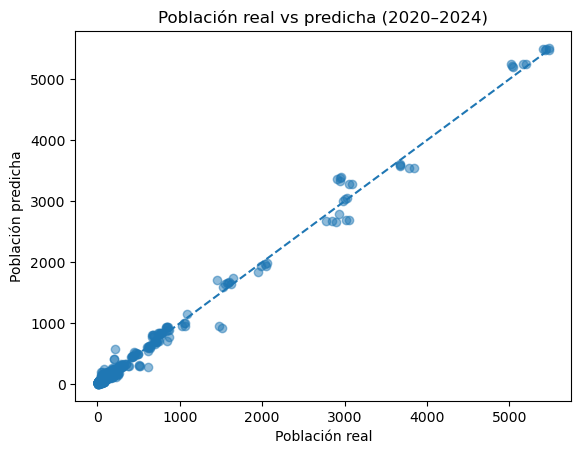

In [44]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)
plt.xlabel("Población real")
plt.ylabel("Población predicha")
plt.title("Población real vs predicha (2020–2024)")
plt.show()

In [49]:
df_test = test_df.copy()
df_test["POBLACION_PREDICHA"] = y_pred
df_test["ERROR"] = df_test["POBLACION_TOTAL"] - df_test["POBLACION_PREDICHA"]
df_test["ERROR_ABS"] = abs(df_test["ERROR"])

df_test.sort_values("ERROR_ABS", ascending=False).head(10)[
    ["COD_MUNICIPIO", "MUNICIPIO", "FECHA",
     "POBLACION_TOTAL", "POBLACION_PREDICHA", "ERROR"]
]

,COD_MUNICIPIO,MUNICIPIO,FECHA,POBLACION_TOTAL,POBLACION_PREDICHA,ERROR
1842,42025,42025 ARCOS DE JALON,2022,1507,927.502519,579.497481
1660,42025,42025 ARCOS DE JALON,2021,1477,954.225468,522.774532
1954,42162,42162 SAN ESTEBAN DE GORMAZ,2022,2910,3367.388700,-457.388700
1590,42162,42162 SAN ESTEBAN DE GORMAZ,2020,2956,3389.493146,-433.493146
1772,42162,42162 SAN ESTEBAN DE GORMAZ,2021,2948,3371.886431,-423.886431
2136,42162,42162 SAN ESTEBAN DE GORMAZ,2023,2950,3323.071855,-373.071855
2268,42095,42095 GOLMAYO,2024,3059,2696.702992,362.297008
2341,42191,42191 VALDEAVELLANO DE TERA,2024,218,578.364094,-360.364094
2139,42165,42165 SAN PEDRO MANRIQUE,2023,614,284.354392,329.645608
2086,42095,42095 GOLMAYO,2023,3014,2696.702992,317.297008


Se analizan las importancias de las variables para identificar los factores que más contribuyen a la predicción de la población municipal.

In [52]:
import pandas as pd

importancias = pd.Series(
    rf.feature_importances_,
    index=variables_predictoras
).sort_values(ascending=False)

importancias

EMPRESAS                     0.981435
ESCUELAS                     0.006011
PROP_POBLACION_EXTRANJERA    0.003505
SERVICIOS_TURISTICOS         0.002944
DISTANCIA_CAPITAL            0.002035
PROP_ENVEJECIMIENTO          0.001867
SERVICIOS_SANIDAD            0.001490
TASA_DEMANDA                 0.000715
dtype: float64

## Proyección de población futura

La proyección de población para el periodo 2025–2030 se realiza a partir del nivel poblacional estimado por el modelo Random Forest para el último año disponible. A partir de este valor base, se construyen escenarios de evolución mediante tasas de variación anual constantes, permitiendo analizar tendencias y escenarios de riesgo demográfico a medio plazo.

In [69]:
df_base = df[df["FECHA"] == 2024].copy()

In [70]:
df_base["POBLACION_BASE_MODELO"] = rf.predict(
    df_base[variables_predictoras]
)

Vamos a marcar dos posibles escenarios: neutro y pesimista 

In [85]:
tasa_neutra = -0.005

tasa_pesimista = -0.015

In [94]:
#escenario neutro
for year in range(2025, 2032):
    df_base[f"POB_PROY_{year}_NEUTRO"] = (
        df_base["POBLACION_BASE_MODELO"] *
        ((1 + tasa_neutra) ** (year - 2024))
    )

In [95]:
#escenario pesimista

for year in range(2025, 2032):
    df_base[f"POB_PROY_{year}_PESIMISTA"] = (
        df_base["POBLACION_BASE_MODELO"] *
        ((1 + tasa_pesimista) ** (year - 2024))
    )

In [96]:
#GUARDAMOS LAS PROYECCIONES EN UN FICHERO CSV

cols_neutro = [f"POB_PROY_{year}_NEUTRO" for year in range(2025, 2032)]

df_neutro = df_base[
    ["COD_MUNICIPIO", "MUNICIPIO"] + cols_neutro
].melt(
    id_vars=["COD_MUNICIPIO", "MUNICIPIO"],
    value_vars=cols_neutro,
    var_name="FECHA",
    value_name="POBLACION_PROYECTADA"
)

df_neutro["ESCENARIO"] = "NEUTRO"


cols_pesimista = [f"POB_PROY_{year}_PESIMISTA" for year in range(2025, 2032)]

df_pesimista = df_base[
    ["COD_MUNICIPIO", "MUNICIPIO"] + cols_pesimista
].melt(
    id_vars=["COD_MUNICIPIO", "MUNICIPIO"],
    value_vars=cols_pesimista,
    var_name="FECHA",
    value_name="POBLACION_PROYECTADA"
)

df_pesimista["ESCENARIO"] = "PESIMISTA"

In [100]:
df_neutro["FECHA"] = df_neutro["FECHA"].str.extract(r"(\d{4})").astype(int)
df_pesimista["FECHA"] = df_pesimista["FECHA"].str.extract(r"(\d{4})").astype(int)

In [106]:
df_proyecciones = pd.concat(
    [df_neutro, df_pesimista],
    ignore_index=True
)

In [107]:
df_proyecciones = df_proyecciones.sort_values(
    ["COD_MUNICIPIO", "FECHA", "ESCENARIO"]
)

df_proyecciones["POBLACION_PROYECTADA"] = (
    np.ceil(df_proyecciones["POBLACION_PROYECTADA"])
    .astype(int)
)
df_proyecciones.head()

,COD_MUNICIPIO,MUNICIPIO,FECHA,POBLACION_PROYECTADA,ESCENARIO
0,42001,42001 ABEJAR,2025,298,NEUTRO
1274,42001,42001 ABEJAR,2025,295,PESIMISTA
182,42001,42001 ABEJAR,2026,297,NEUTRO
1456,42001,42001 ABEJAR,2026,291,PESIMISTA
364,42001,42001 ABEJAR,2027,295,NEUTRO


In [110]:
df_proyecciones.to_csv(
    "proyeccion_poblacion_2025_2031.csv",
    index=False
)